1) Feature extraction from VGG16 + XGBoost Classification

2) Feature Extraction from VGG19 + EfficientNet FC


3) RandomCrop Augmentation Implementation 

**Note**
* Work with CPU until runtime then switch to GPU using one of the available platforms

 (Kaggle , Colab , Paperspace, Slurm Cluster)

# Explanation

1) להעביר תמונה דרך רשת AlexNet מאומנת וכל שכבת Max Pool 3*3 להחליף בשכבת Global Max Pool מתאימה כדי לקבל פלט של 1*1*Num of channels

2) לחבר את כל הפלטים (פי׳צרים) 

3)לייצר DF עם הלייבלים המתאימים 

4)לפצל לtrain ו test 

5)לאמן  XGBoost

ב1- לא מחליפים את הmaxpool 

במקום זה מוסיפים globalmaxpool לforward כדי להוציא את הוקטורים המייצגים

מוסיפים global Max pool אחרי כל max pool

# Imports

In [ ]:
from __future__ import print_function, division

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from  torch.utils.data import Dataset, DataLoader

from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.detection.backbone_utils import LastLevelMaxPool
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork

import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import io
import time
import copy

**Give access to drive to all data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(f'device is: {device}')

device is: cuda


# Set hyper-parameters & construct dataset and dataloader

In [ ]:
data_dir = '/content/drive/MyDrive/Birds_implemention'
lr = 1e-2
epochs = 10 # to_check
num_of_classes = 450
criterion = nn.CrossEntropyLoss()
TRAIN = 'train'
VAL = 'valid'
TEST = 'test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=2,
        shuffle=True, num_workers=2
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 70686 images under train
Loaded 2250 images under valid
Loaded 2250 images under test
Classes: 
['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN FLAMINGO', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'AMERICAN WIGEON', 'AMETHYST WOODSTAR', 'ANDEAN GOOSE', 'ANDEAN LAPWING', 'ANDEAN SISKIN', 'ANHINGA', 'ANIANIAU', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ANTILLEAN EUPHONIA', 'APAPANE', 'APOSTLEBIRD', 'ARARIPE MANAKIN', 'ASHY STORM PETREL', 'ASHY THRUSHBIRD', 'ASIAN CRESTED IBIS', 'ASIAN DOLLARD BIRD', 'AUCKLAND SHAQ', 'AUSTRAL CANASTERO', 'AUSTRALASIAN FIGBIRD', 'AVADAVAT', 'AZARAS SPINETAIL', 'AZURE BREASTED PITTA', 'AZURE JAY', 'AZURE TANAGER', 'AZURE 

# Visual the Data

**Utils**

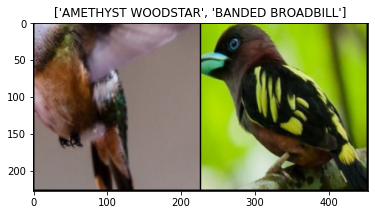

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    #plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [ ]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]
        
        with torch.no_grad():
          if device is 'cuda':
              inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
          else:
              inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state

*This helper function will give us the accuracy of our model on the test set.*

In [ ]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[TEST]):
        if i % 10 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data
        
        with torch.no_grad():
          if device is 'cuda':
              inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
          else:
              inputs, labels = Variable(inputs), Variable(labels)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.data
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

# Model Creation

**להשלים**

In [ ]:
if device is 'cuda':
    vgg16.cuda() #.cuda() will move everything to the GPU side
  
optimizer_ft = optim.SGD(vgg16.parameters(), lr=lr, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

*Test before training*

In [ ]:
print("Test before training")
eval_model(vgg16, criterion)

Test before training
Evaluating model
----------
Test batch 1120/1125
Evaluation completed in 23m 24s
Avg loss (test): 3.0736
Avg acc (test): 0.0018
----------


Ground truth:


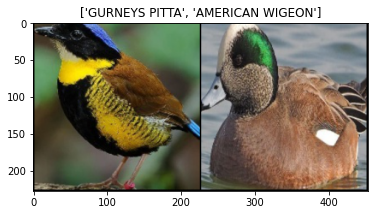

Prediction:


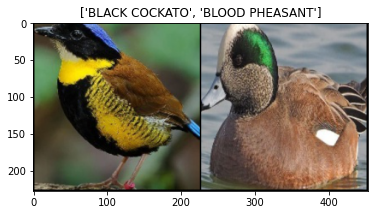

Ground truth:


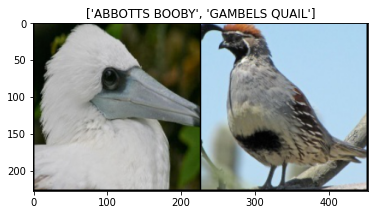

Prediction:


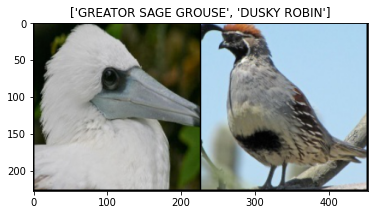

Ground truth:


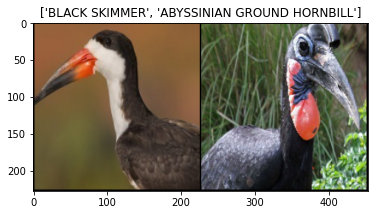

Prediction:


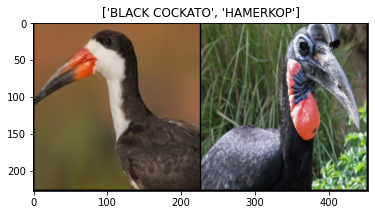

In [ ]:
visualize_model(vgg16) #test before training

**Not a great results yet**

# Train Model

In [ ]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 10 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)
                
            # Use half training dataset
            if i >= train_batches / 2:
                break
                
            inputs, labels = data
            
            if device is 'cuda':
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * 2 / dataset_sizes[TRAIN]
        avg_acc = acc_train * 2 / dataset_sizes[TRAIN]
        
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(dataloaders[VAL]):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            if device is 'cuda':
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.data
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_sizes[VAL]
        avg_acc_val = acc_val / dataset_sizes[VAL]
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [ ]:
vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)
torch.save(vgg16.state_dict(), 'VGG16_v2-OCT_Retina_half_dataset.pt')

Epoch 0/2
----------
Training batch 90/17671.5

KeyboardInterrupt: ignored

# Feature Extraction

In [ ]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')
print(vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False
summary (vgg16, (3,224,224))
# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-8] # Remove all flatten layers
#features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 450 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

**Shows the name of layers**

In [ ]:
train_nodes, eval_nodes2 = get_graph_node_names(vgg16)
print(train_nodes)

['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'features.27', 'features.28', 'features.29', 'features.30', 'avgpool', 'flatten']


**Create moudle with new feature**

In [ ]:
class new_Vgg16_Birds(nn.Module):
    def __init__(self):
        super(new_Vgg16_Birds, self).__init__()
        self.pool_1 = nn.MaxPooling2D(112)
        self.pool_1 = nn.MaxPooling2D(112)
        self.pool_1 = nn.MaxPooling2D(112)
        self.pool_1 = nn.MaxPooling2D(112)
        self.select = ['7', '14', '21', '28']
        self.vgg = vgg16.features

        # Extract 4 main layers
        self.body = create_feature_extractor(
            vgg16, return_nodes={f'features.{k}': str(v)
                             for v, k in enumerate(self.select)})
        

        # Dry run to get number of channels for FPN
        inp = torch.randn(2, 3, 224, 224)
        with torch.no_grad():
            out = self.body(inp)
        in_channels_list = [o.shape[1] for o in out.values()]
        # Build FPN
        self.out_channels = 256
        self.fpn = FeaturePyramidNetwork(
            in_channels_list, out_channels=self.out_channels,
            extra_blocks=LastLevelMaxPool())

    def forward(self, x):
        x = self.body(x)
        x = self.fpn(x)
        features = []
        for name, layer in self.vgg._modules.items():
            print(name, layer)
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features
        return x


In [ ]:
new_vgg16 = new_Vgg16_Birds()

In [ ]:
print(new_vgg16.fpn)

FeaturePyramidNetwork(
  (inner_blocks): ModuleList(
    (0): Conv2dNormActivation(
      (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): Conv2dNormActivation(
      (0): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (3): Conv2dNormActivation(
      (0): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (layer_blocks): ModuleList(
    (0): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (extra_blocks): LastLevelMaxPool()
)
